In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from dataloader import get_evaluation_datasets_by_client  # Assuming this function gets local client datasets
from model import Net
from collections import OrderedDict
from config import NUM_CLASSES, NUM_CLIENTS, GLOBAL_MODEL_PATH, BATCH_SIZE
from torch.utils.data import DataLoader
from utils import to_tensor
import pandas as pd
import pickle
import time

/home/sharedrive/PythonCodes/.venv311_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
result_sources = {
    'components': [17],
    'folds': [1, 2, 3, 4, 5],
    #'folds': [1, 2],
    'marker': ['o', '-', '^' 'x', '-o-'],
    'clients': [1, 2, 3, 4],
    'path': './results/original_{0}_fold_{1}'
}

## 1. Helper Functions

In [3]:
# Load the global model from the saved path
def load_model(model_path=GLOBAL_MODEL_PATH, num_classes=NUM_CLASSES):
    model = Net(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [4]:
# Run inference on a client's dataset
def run_inference(model, dataloader, device):
    all_preds = []
    all_labels = []

    # Get the total number of samples from the DataLoader
    total_samples = len(dataloader.dataset)
    # Start the timer before the loop
    start_time = time.time()
    
    with torch.no_grad():
        for batch in dataloader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(features)
            _, preds = torch.max(outputs.data, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # End the timer after the loop
    end_time = time.time()    
    # Calculate the total inference time
    total_inference_time = end_time - start_time    
    # Calculate average inference time per sample
    #inference_time_per_sample =  total_inference_time * 1000
    inference_time_per_sample =  total_inference_time * 1000000 / total_samples
    
    return np.array(all_preds), np.array(all_labels), f'{inference_time_per_sample:.4f} us'

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass ax here directly
    ax.set_title(title)  # Optional: Set a title for each subplot


## 2. Performance/History of Global Model

In [6]:
## This will read pickle file and return the metrics
def parse_history(history_path):
    with open(history_path, 'rb') as file:
        history = pickle.load(file)
        # Extract distributed and centralized losses
        loss_distributed = [loss for _, loss in history.losses_distributed]
        loss_centralized = [loss for _, loss in history.losses_centralized]
        
        # Extract accuracy for distributed and centralized evaluation
        accuracy_distributed = [acc for _, acc in history.metrics_distributed['accuracy']]
        accuracy_centralized = [acc for _, acc in history.metrics_centralized['accuracy']]

        return loss_distributed, loss_centralized, accuracy_distributed, accuracy_centralized
    

In [7]:
##Parse the Training Time
def parse_training_time(time_path):
    # Open the text file and read the value
    with open(time_path, 'r') as file:
    # Read the content of the file and strip any extra spaces or newlines
        content = file.read().strip()
    # Convert the content to a float, round it, and cast it to an integer
    rounded_value = round(float(content))
    return int(rounded_value)


In [8]:
def plot_metrics(y_true, y_pred, classes, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass ax here directly
    ax.set_title(title)  # Optional

### 2.1 Accuracy/Loss vs Round

2024-11-27 19:34:35,565	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/sharedrive/PythonCodes/.venv311_new/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


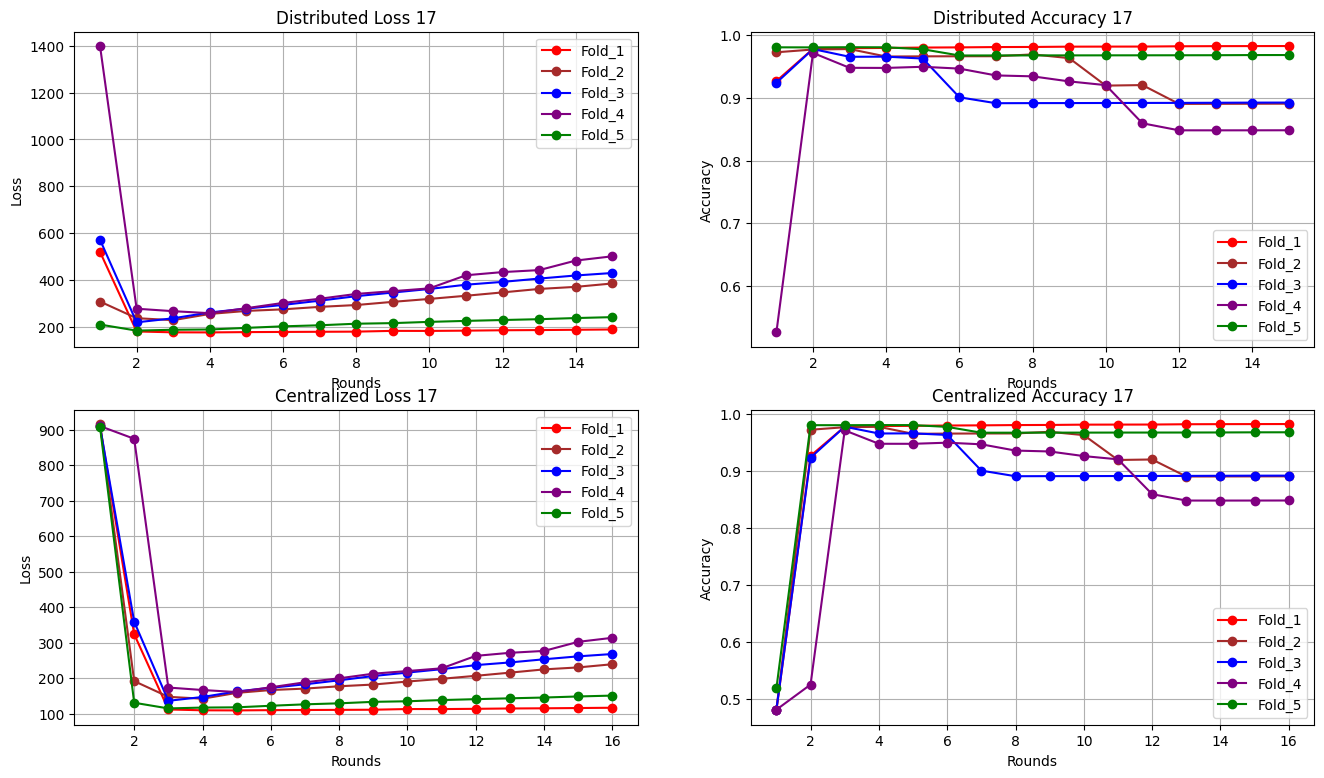

In [9]:
for component in result_sources.get('components'):    
    loss_distributed = [] 
    loss_centralized = [] 
    accuracy_distributed =[] 
    accuracy_centralized = []
   
    for fold in result_sources.get('folds'):
        history_path = result_sources.get('path').format(component, fold) + '/history.pkl'        
        l_d, l_c, a_d, a_c = parse_history(history_path)        
        loss_distributed.append(l_d)
        loss_centralized.append(l_c)
        accuracy_distributed.append(a_d)
        accuracy_centralized.append(a_c)

    history_plots = [
        {
            'type': 'distributed_loss',
            'plot_name': 'Distributed Loss {}',
            'x': 'Rounds',
            'y': 'Loss',
            'plot_position': [0, 0],
            'data': loss_distributed,
            'colors': ['red', 'brown', 'blue', 'purple', 'green']
        },
        {
            'type': 'accuracy_distributed',
            'plot_name': 'Distributed Accuracy {}',
            'x': 'Rounds',
            'y': 'Accuracy',
            'plot_position': [0, 1],
            'data': accuracy_distributed,
            'colors': ['red', 'brown', 'blue', 'purple', 'green']
        },
         {
            'type': 'centralized_loss',
            'plot_name': 'Centralized Loss {}',
            'x': 'Rounds',
            'y': 'Loss',
            'plot_position': [1, 0],
            'data': loss_centralized,
            'colors': ['red', 'brown', 'blue', 'purple', 'green']
        },
        {
            'type': 'centralized_accuracy',
            'plot_name': 'Centralized Accuracy {}',
            'x': 'Rounds',
            'y': 'Accuracy',
            'plot_position': [1, 1],
            'data': accuracy_centralized,
            'colors': ['red', 'brown', 'blue', 'purple', 'green']
        },     
      
    ]

    fig, ax = plt.subplots(2, 2, figsize=(16, 9))  # Adjust the figsize as needed
    for plot in  history_plots:
        position = plot.get('plot_position')
        all_fold_data = plot.get('data')
        #print(len(all_fold_data))
        for i, data in enumerate(all_fold_data):
            rounds = list(range(1, len(data)+1))
            ax[position[0], position[1]].plot(rounds, data, label=f'Fold_{i+1}', marker='o', color=plot.get('colors')[i])
            ax[position[0], position[1]].set_title(plot.get('plot_name').format(component))
            ax[position[0], position[1]].set_xlabel(plot.get('x'))
            ax[position[0], position[1]].set_ylabel(plot.get('y'))
            ax[position[0], position[1]].legend()
            ax[position[0], position[1]].grid(True)
            
            


### 2.2 Training Time

In [10]:
##Plotting the Time charts
for component in result_sources.get('components'):
    training_time = []
    for fold in result_sources.get('folds'):
        ##Parsign the training time
        training_time_path = result_sources.get('path').format(component, fold) + '/training_time.txt'
        training_time = parse_training_time(training_time_path)
        print(f'[Component {component} Fold {fold}]: {training_time} Seconds')
   

[Component 17 Fold 1]: 1733 Seconds
[Component 17 Fold 2]: 1932 Seconds
[Component 17 Fold 3]: 1733 Seconds
[Component 17 Fold 4]: 2277 Seconds
[Component 17 Fold 5]: 1754 Seconds


## 3. Accumulate Results
- Accumulate all thre results and save in csv file
- It also stores values reauired for confusion matrix in a varialbe

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
client_metrics = {
    'Component': [],
    'Fold': [],
    'Client': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1_Score': [],
    'Sample_Number': [],
    'Inference_Time_Per_Sample': []
}

classes = np.arange(NUM_CLASSES)  # Define or import this variable

def accumulate_results(results, confusion_matrix_data, model_to_use):
    components = results.get('components')
    folds = results.get('folds')
    path = results.get('path')
    clients = results.get('clients')
    for component in components:  
        for fold in folds:
            global_model = path.format(component, fold) + '/' + model_to_use
            history = path.format(component, fold) + '/' + 'history.pkl'
            #training_time = path.format(component, fold) + '/' + 'training_time.txt'
            
            model = load_model(model_path=global_model)
            model.to(device)    
            num_clients = NUM_CLIENTS  # Define or import this variable    
            
            for client in clients:                                
                testset = get_evaluation_datasets_by_client(client, fold) 
                #print(testset.shape())
                testloader = DataLoader(to_tensor(testset), batch_size=BATCH_SIZE)
                preds, labels, inference_time_per_sample = run_inference(model, testloader, device)
                client_metrics['Component'].append(component)
                client_metrics['Fold'].append(fold)
                client_metrics['Client'].append(client)
                client_metrics['Accuracy'].append(accuracy_score(labels, preds))
                client_metrics['Precision'].append(precision_score(labels, preds))
                client_metrics['Recall'].append(recall_score(labels, preds))
                client_metrics['F1_Score'].append(f1_score(labels, preds))
                client_metrics['Sample_Number'].append(len(labels)),
                client_metrics['Inference_Time_Per_Sample'].append(inference_time_per_sample)

                #Saving info for confusion matrix
                key = f'{component}_{fold}_{client}'
                confusion_matrix_data[key] = {
                    'preds': preds,
                    'labels': labels,
                    'classes': np.arange(NUM_CLASSES)
                }   

    ##Converting into datafram for better visualization
    df = pd.DataFrame(client_metrics)
    print(df.to_string(index=False))
    return df, confusion_matrix_data           
    

In [12]:
confusion_matrix_data = {}
result_df, store_results_df = accumulate_results(result_sources, confusion_matrix_data, 'best_global_model.pth')

 Component  Fold  Client  Accuracy  Precision   Recall  F1_Score  Sample_Number Inference_Time_Per_Sample
        17     1       1  0.972631   0.949732 1.000000  0.974218          84000                19.8384 us
        17     1       2  0.973643   0.954840 1.000000  0.976899          84000                 5.5255 us
        17     1       3  0.993036   0.986308 0.999952  0.993084          84000                 5.5002 us
        17     1       4  0.991333   0.982985 0.999976  0.991408          84000                 5.5193 us
        17     2       1  0.971107   0.947082 1.000000  0.972822          84000                 5.4913 us
        17     2       2  0.974607   0.956420 1.000000  0.977724          84000                 6.7510 us
        17     2       3  0.981762   0.971457 0.992690  0.981959          84000                 5.5043 us
        17     2       4  0.983905   0.968813 1.000000  0.984160          84000                 5.5325 us
        17     3       1  0.972024   0.948693 

## 4. Confusion Matrix (per client per Fold)

In [13]:
plots = [
    {
        'client_id': 1,
        'plot_name': 'Client 1',
        'plot_position': [0, 0]
    },
    {
        'client_id': 2,
        'plot_name': 'Client 2',
        'plot_position': [0, 1]
    },
    {
        'client_id': 3,
        'plot_name': 'Client 3',
        'plot_position': [1, 0]
    },
    {
        'client_id': 4,
        'plot_name': 'Client 4',
        'plot_position': [1, 1]
    }   
]

In [14]:

# for component in result_sources.get('components'):
#     for fold in result_sources.get('folds'):
#         #print(f" Plots for Components: {component}, and Folds: {fold}")
#         fig, ax = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figsize as needed
#         for plot in plots:
#             client = plot.get('client_id')
#             key = f'{component}_{fold}_{client}'
#             data = confusion_matrix_data[key]
#             title = "{0} ({1}_{2})".format(plot['plot_name'], component, fold)
#             plot_confusion_matrix(data['labels'], data['preds'], data['classes'], title, ax = ax[plot['plot_position'][0], plot['plot_position'][1]])
#         plt.tight_layout()
#         plt.show()
#         print("---------------------------------------------------------------------------------------------------------------------------------")
#         print("---------------------------------------------------------------------------------------------------------------------------------")



## 5. Accumulate All the Training/Validaiton Metrics

In [15]:
components =  result_sources.get('components')
folds =  result_sources.get('folds')
path =  result_sources.get('path')
#clients = results.get('clients')

metric_dfs = []
for component in components:  
    for fold in folds:
        metric_path = path.format(component, fold) + '/' + 'metrics.csv'
        metric_df = pd.read_csv(metric_path)
        metric_df['fold'] = fold
        metric_dfs.append(metric_df)

#merging
merged_df = pd.concat(metric_dfs, ignore_index=True)
merged_df.to_csv(f"./results/accumulted_metrics_{components[0]}.csv")

## 5. Accumulate All Local Metrics

In [16]:
components =  result_sources.get('components')
folds =  result_sources.get('folds')
path =  result_sources.get('path')
clients = result_sources.get('clients')

local_training_dfs = []
for component in components:
    for fold in folds:
        for client in clients:
            local_training_history_path = path.format(component, fold) + f"/local_train_history_{client}.csv"
            local_training_df = pd.read_csv(local_training_history_path)
            local_training_df['fold'] = fold
            local_training_dfs.append(local_training_df)

#merging
local_training_dfs_merged = pd.concat(local_training_dfs, ignore_index=True)
local_training_dfs_merged.to_csv(f"./results/local_training_metrics_{components[0]}.csv")
